# Initialisation du notebook 01

In [27]:
import os
from pathlib import Path
import sys

import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

# --- Vérification TensorFlow ---
print("TensorFlow version:", tf.__version__)
print("GPU Available:", "Yes" if tf.config.list_physical_devices('GPU') else "No")

# --- Définition des chemins du projet ---
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
NOTEBOOKS = PROJECT_ROOT / "notebooks"
MODELS = PROJECT_ROOT / "models"

print("Project root:", PROJECT_ROOT)
print("Raw data folder:", DATA_RAW)
print("Processed data folder:", DATA_PROCESSED)
print("Models folder:", MODELS)

# --- Configuration affichage numpy/pandas/matplotlib ---
np.set_printoptions(suppress=True)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = False

# --- Vérification de l'existence des dossiers importants ---
assert DATA_RAW.exists(), "Le dossier data/raw n'existe pas. Vérifier la structure."
assert (DATA_RAW / "leftImg8bit").exists(), "leftImg8bit manquant."
assert (DATA_RAW / "gtFine").exists(), "gtFine manquant."

print("Initialisation terminée. Environnement du notebook prêt.")

TensorFlow version: 2.16.1
GPU Available: No
Project root: c:\Users\vicau\P8OC
Raw data folder: c:\Users\vicau\P8OC\data\raw
Processed data folder: c:\Users\vicau\P8OC\data\processed
Models folder: c:\Users\vicau\P8OC\models
Initialisation terminée. Environnement du notebook prêt.


# Exploration des données 

## Liste des villes disponibles

In [28]:
left_train_dir = DATA_RAW / "leftImg8bit" / "train"
gt_train_dir = DATA_RAW / "gtFine" / "train"

# Vérification existence
assert left_train_dir.exists(), f"Chemin introuvable : {left_train_dir}"
assert gt_train_dir.exists(), f"Chemin introuvable : {gt_train_dir}"

left_cities = sorted([d.name for d in left_train_dir.iterdir() if d.is_dir()])
gt_cities = sorted([d.name for d in gt_train_dir.iterdir() if d.is_dir()])

print("Villes trouvées dans leftImg8bit/train :")
print(left_cities)
print("\nVilles trouvées dans gtFine/train :")
print(gt_cities)

# Vérification de cohérence entre les deux dossiers
missing_in_gt = set(left_cities) - set(gt_cities)
missing_in_left = set(gt_cities) - set(left_cities)

if missing_in_gt:
    print("\nAttention : ces villes existent dans leftImg8bit mais pas dans gtFine :", missing_in_gt)

if missing_in_left:
    print("\nAttention : ces villes existent dans gtFine mais pas dans leftImg8bit :", missing_in_left)

Villes trouvées dans leftImg8bit/train :
['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']

Villes trouvées dans gtFine/train :
['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']


# Preprocessing des données

##  Chargement d'une image + mask

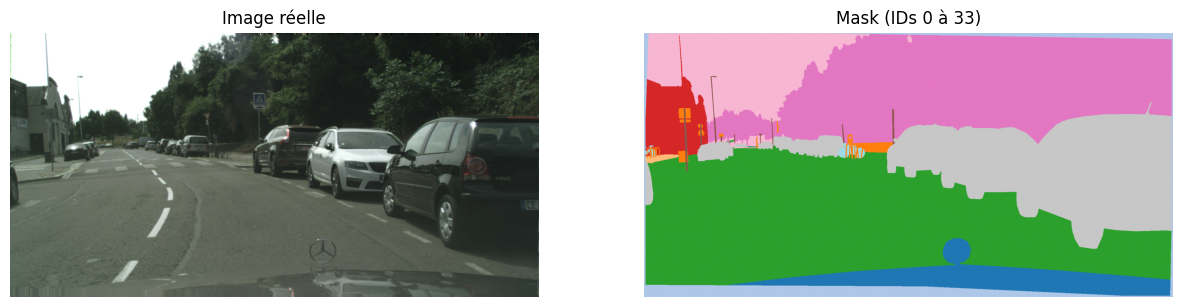

Image path : c:\Users\vicau\P8OC\data\raw\leftImg8bit\train\strasbourg\strasbourg_000000_000065_leftImg8bit.png
Mask path : c:\Users\vicau\P8OC\data\raw\gtFine\train\strasbourg\strasbourg_000000_000065_gtFine_labelIds.png
Image shape : (1024, 2048, 3)
Mask shape : (1024, 2048)
Valeurs uniques du mask : [ 0  1  2  3  4  6  7  8 11 17 20 21 22 23 26 33]


In [29]:
import matplotlib.pyplot as plt

# Choix d'une ville de test
test_city = "strasbourg"

left_city_dir = DATA_RAW / "leftImg8bit" / "train" / test_city
gt_city_dir = DATA_RAW / "gtFine" / "train" / test_city

# Sélection d'une image (première du dossier)
left_images = sorted([f for f in left_city_dir.iterdir() if f.suffix == ".png"])
assert len(left_images) > 0, f"Aucune image trouvée dans {left_city_dir}"

image_path = left_images[0]

# Construction du nom du mask correspondant
mask_filename = image_path.name.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
mask_path = gt_city_dir / mask_filename

assert mask_path.exists(), f"Mask correspondant introuvable : {mask_path}"

# Chargement image RGB
image = cv2.imread(str(image_path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Chargement mask (labelIds)
mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)

# Affichage
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image réelle")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="tab20")
plt.title("Mask (IDs 0 à 33)")
plt.axis("off")

plt.show()

print("Image path :", image_path)
print("Mask path :", mask_path)
print("Image shape :", image.shape)
print("Mask shape :", mask.shape)
print("Valeurs uniques du mask :", np.unique(mask))

## 34 classes -> 8 classes (simplification)


Mapping des 34 classes Cityscapes -> 8 classes :
------------------------------------------------
0 : background           -> [0,1,2,3,4,5,6]
1 : road                 -> [7]
2 : sidewalk             -> [8]
3 : building             -> [11]
4 : other construction   -> [12,13,14,15,16]
5 : object               -> [17,18,19,20]
6 : vegetation           -> [21,22]
7 : vehicle              -> [23,24,25,26,27,28,29,30,31,32,33]



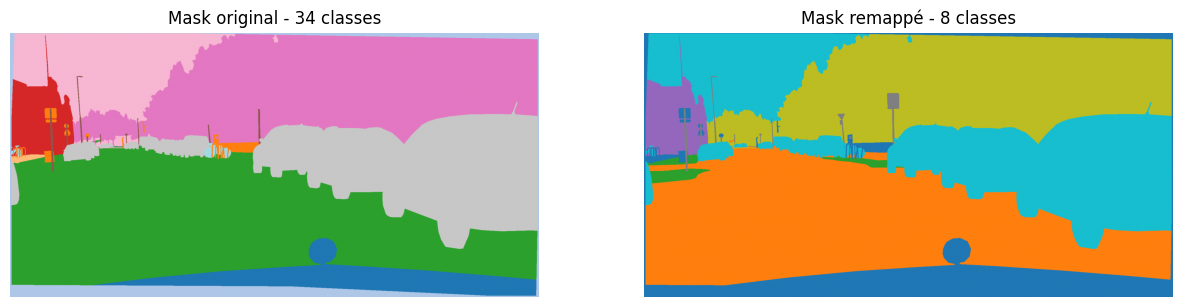

Valeurs uniques dans le mask 34 classes : [ 0  1  2  3  4  6  7  8 11 17 20 21 22 23 26 33]
Valeurs uniques dans le mask 8 classes  : [0 1 2 3 5 6 7]


In [30]:
# Tableau explicatif (affiché dans le notebook pour référence)
mapping_explanation = """
Mapping des 34 classes Cityscapes -> 8 classes :
------------------------------------------------
0 : background           -> [0,1,2,3,4,5,6]
1 : road                 -> [7]
2 : sidewalk             -> [8]
3 : building             -> [11]
4 : other construction   -> [12,13,14,15,16]
5 : object               -> [17,18,19,20]
6 : vegetation           -> [21,22]
7 : vehicle              -> [23,24,25,26,27,28,29,30,31,32,33]
"""
print(mapping_explanation)

# Dictionnaire complet
CITYSCAPES_34_TO_8 = {
    0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0,      # background
    7:1,                                    # road
    8:2,                                    # sidewalk
    11:3,                                   # building
    12:4, 13:4, 14:4, 15:4, 16:4,            # other construction
    17:5, 18:5, 19:5, 20:5,                  # object
    21:6, 22:6,                              # vegetation
    # vehicle
    23:7, 24:7, 25:7, 26:7, 27:7, 28:7, 
    29:7, 30:7, 31:7, 32:7, 33:7
}

# Fonction pour appliquer le mapping
def map_34_to_8(mask, mapping_dict):
    h, w = mask.shape
    new_mask = np.zeros((h, w), dtype=np.uint8)
    for old_id, new_id in mapping_dict.items():
        new_mask[mask == old_id] = new_id
    return new_mask

# Application du mapping sur le mask chargé précédemment
mapped_mask = map_34_to_8(mask, CITYSCAPES_34_TO_8)

# Affichage comparatif
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.imshow(mask, cmap="tab20")
plt.title("Mask original - 34 classes")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mapped_mask, cmap="tab10")
plt.title("Mask remappé - 8 classes")
plt.axis("off")

plt.show()

print("Valeurs uniques dans le mask 34 classes :", np.unique(mask))
print("Valeurs uniques dans le mask 8 classes  :", np.unique(mapped_mask))


## Sous-ensemble dans data/processed

In [31]:
import shutil

# ============================================================
# Création du sous-ensemble Cityscapes dans data/processed
# ============================================================

# --- Fonction utilitaire pour lister les villes existantes ---
def list_cities(split):
    """
    Retourne la liste des villes disponibles pour un split donné
    (train / val / test) dans leftImg8bit.
    """
    split_dir = DATA_RAW / "leftImg8bit" / split
    assert split_dir.exists(), f"Dossier introuvable : {split_dir}"
    cities = sorted([d.name for d in split_dir.iterdir() if d.is_dir()])
    return cities

# Liste des villes réellement présentes dans chaque split
train_cities_all = list_cities("train")
val_cities_all   = list_cities("val")
test_cities_all  = list_cities("test")

print("Villes disponibles (train) :", train_cities_all)
print("Villes disponibles (val)   :", val_cities_all)
print("Villes disponibles (test)  :", test_cities_all)

# --- Sélection du sous-ensemble utilisé ---
# (les nombres peuvent être ajustés en fonction de la taille souhaitée du sous-ensemble)
train_cities = train_cities_all[:3]    # ex : 3 villes pour l'entraînement
val_cities   = val_cities_all[:1]      # 1 ville pour la validation
test_cities  = test_cities_all[:1]     # 1 ville pour le test

print("\nVilles utilisées pour TRAIN :", train_cities)
print("Villes utilisées pour VAL   :", val_cities)
print("Villes utilisées pour TEST  :", test_cities)

# --- Dossier cible ---
processed_images = DATA_PROCESSED / "images"
processed_masks  = DATA_PROCESSED / "masks"

# Création / nettoyage de la structure de dossiers
# ⚠️ Le contenu existant est supprimé afin de repartir sur une structure propre.
for split in ["train", "val", "test"]:
    img_dir = processed_images / split
    mask_dir = processed_masks / split

    if img_dir.exists():
        shutil.rmtree(img_dir)
    if mask_dir.exists():
        shutil.rmtree(mask_dir)

    img_dir.mkdir(parents=True, exist_ok=True)
    mask_dir.mkdir(parents=True, exist_ok=True)

print("\nDossiers data/processed recréés (images & masks).")

# --- Fonction utilitaire pour copie ---
def copy_city(split, city):
    """
    Copie l'ensemble des images et des masks d'une ville donnée
    depuis data/raw vers data/processed pour un split donné.
    """
    src_img = DATA_RAW / "leftImg8bit" / split / city
    src_mask = DATA_RAW / "gtFine" / split / city

    if not src_img.exists() or not src_mask.exists():
        print(f"[SKIP] Dossier manquant pour {split}/{city}")
        return

    for img_path in sorted(src_img.glob("*.png")):
        # Nom du mask correspondant
        mask_name = img_path.name.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
        mask_path = src_mask / mask_name

        # Vérifications
        if not mask_path.exists():
            print(f"WARNING: mask introuvable pour {img_path.name}")
            continue

        # Copie vers processed/
        dst_img = processed_images / split / img_path.name
        dst_mask = processed_masks / split / mask_name

        shutil.copy(img_path, dst_img)
        shutil.copy(mask_path, dst_mask)

        print(f"[{split}] {city} : {img_path.name} copié")

# --- Copie des villes pour chaque split ---
print("\n=== Copie TRAIN ===")
for city in train_cities:
    copy_city("train", city)

print("\n=== Copie VAL ===")
for city in val_cities:
    copy_city("val", city)

print("\n=== Copie TEST ===")
for city in test_cities:
    copy_city("test", city)

print("\nSous-ensemble créé dans data/processed/")


Villes disponibles (train) : ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']
Villes disponibles (val)   : ['frankfurt', 'lindau', 'munster']
Villes disponibles (test)  : ['berlin', 'bielefeld', 'bonn', 'leverkusen', 'mainz', 'munich']

Villes utilisées pour TRAIN : ['aachen', 'bochum', 'bremen']
Villes utilisées pour VAL   : ['frankfurt']
Villes utilisées pour TEST  : ['berlin']

Dossiers data/processed recréés (images & masks).

=== Copie TRAIN ===
[train] aachen : aachen_000000_000019_leftImg8bit.png copié
[train] aachen : aachen_000001_000019_leftImg8bit.png copié
[train] aachen : aachen_000002_000019_leftImg8bit.png copié
[train] aachen : aachen_000003_000019_leftImg8bit.png copié
[train] aachen : aachen_000004_000019_leftImg8bit.png copié
[train] aachen : aachen_000005_000019_leftImg8bit.png copié
[train] aachen : aachen_00000

# Test du générateur dataloader.py

Nombre d'images train : 586
Nombre de masks train : 586
Shapes du batch :
X : (2, 256, 512, 3)
y : (2, 256, 512, 8)


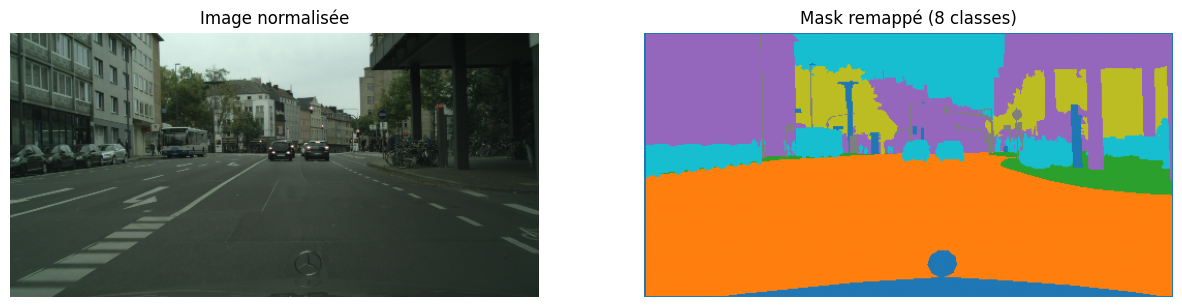

Valeurs uniques du mask : [0 1 2 3 5 6 7]


In [32]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# --- Ajout du dossier src/ au path Python ---
import sys
sys.path.append(str(PROJECT_ROOT / "src"))

# --- Import du générateur ---
from dataloader import CityscapesSequence # type: ignore

# --- Dossiers processed ---
images_train_dir = PROJECT_ROOT / "data" / "processed" / "images" / "train"
masks_train_dir  = PROJECT_ROOT / "data" / "processed" / "masks" / "train"

# --- Récupération des chemins ---
image_paths = sorted(list(images_train_dir.glob("*.png")))
mask_paths  = sorted(list(masks_train_dir.glob("*.png")))

print(f"Nombre d'images train : {len(image_paths)}")
print(f"Nombre de masks train : {len(mask_paths)}")

# --- Création du générateur ---
gen = CityscapesSequence(
    image_paths=image_paths,
    mask_paths=mask_paths,
    batch_size=2,
    target_size=(256, 512),
    augment=False,
    n_classes=8,
    shuffle=True
)

# --- Récupération d'un batch ---
X, y = gen[0]

print("Shapes du batch :")
print("X :", X.shape)
print("y :", y.shape)

# --- Affichage d'une image + mask ---
idx = 0
img = X[idx]
mask = np.argmax(y[idx], axis=-1)   # revenir au mask 0-7

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Image normalisée")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="tab10")
plt.title("Mask remappé (8 classes)")
plt.axis("off")

plt.show()

print("Valeurs uniques du mask :", np.unique(mask))


# Selection des modeles 

## Metriques 

In [33]:
# ============================================================
# Métriques + Losses + Outil de Temps
# ============================================================

import tensorflow as tf
import numpy as np
import time

# ---------------------------
# 1) METRIQUES
# ---------------------------

def iou_metric(y_true, y_pred, smooth=1e-6):
    """
    IoU moyen (Jaccard) sur toutes les classes.
    y_true et y_pred sont de forme (B, H, W, C) en one-hot (pour y_true)
    et probabilités (softmax) pour y_pred.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    num_classes = tf.shape(y_true)[-1]

    # Convertir y_pred en labels discrets puis en one-hot
    y_pred_labels = tf.argmax(y_pred, axis=-1)                 # (B, H, W)
    y_pred_one_hot = tf.one_hot(y_pred_labels, depth=num_classes)  # (B, H, W, C)

    # Mise à plat
    y_true_f = tf.reshape(y_true, [-1, num_classes])
    y_pred_f = tf.reshape(y_pred_one_hot, [-1, num_classes])

    # Intersection et union par classe
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f + y_pred_f, axis=0) - intersection

    iou_per_class = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou_per_class)


def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )


def pixel_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    correct = tf.equal(y_true, y_pred)
    return tf.reduce_mean(tf.cast(correct, tf.float32))


# ---------------------------
# 2) LOSSES
# ---------------------------

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def balanced_cross_entropy(beta=0.5):
    def loss_fn(y_true, y_pred):
        ce = tf.keras.losses.CategoricalCrossentropy()
        return beta * ce(y_true, y_pred)
    return loss_fn


# ---------------------------
# 3) MESURE TEMPS INFERENCE
# ---------------------------

def measure_inference_time(model, sample_input, n_runs=20):
    start = time.time()
    for _ in range(n_runs):
        _ = model.predict(sample_input, verbose=0)
    end = time.time()
    avg = (end - start) / n_runs
    print(f"Temps d'inférence moyen : {avg:.4f} sec par image")
    return avg


### U-Net Mini (baseline)

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models  # type: ignore

def unet_mini(input_shape=(256, 512, 3), num_classes=8):

    inputs = layers.Input(shape=input_shape)

    # Encoder
    x1 = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x1 = layers.Conv2D(32, 3, padding='same', activation='relu')(x1)
    p1 = layers.MaxPooling2D((2, 2))(x1)

    x2 = layers.Conv2D(64, 3, padding='same', activation='relu')(p1)
    x2 = layers.Conv2D(64, 3, padding='same', activation='relu')(x2)
    p2 = layers.MaxPooling2D((2, 2))(x2)

    # Bottleneck
    b = layers.Conv2D(128, 3, padding='same', activation='relu')(p2)
    b = layers.Conv2D(128, 3, padding='same', activation='relu')(b)

    # Decoder
    u3 = layers.UpSampling2D((2, 2))(b)
    u3 = layers.Concatenate()([u3, x2])
    x3 = layers.Conv2D(64, 3, padding='same', activation='relu')(u3)
    x3 = layers.Conv2D(64, 3, padding='same', activation='relu')(x3)

    u4 = layers.UpSampling2D((2, 2))(x3)
    u4 = layers.Concatenate()([u4, x1])
    x4 = layers.Conv2D(32, 3, padding='same', activation='relu')(u4)
    x4 = layers.Conv2D(32, 3, padding='same', activation='relu')(x4)

    # Output (8 classes)
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(x4)

    model = models.Model(inputs, outputs, name="UNet_Mini")

    # Compilation avec métriques (Keras 3 friendly)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=dice_loss,
        metrics=[iou_metric, dice_coef, pixel_accuracy]
    )

    return model


# ============================================================
# Instanciation du modèle
# ============================================================

model_unet_mini = unet_mini()


# ============================================================
# Mini-évaluation automatique (compatible Keras 3)
# ============================================================

# 1) Vérifier les métriques attachées
print("Métriques configurées :", model_unet_mini.metrics_names)

# 2) Charger un batch depuis le générateur
X_batch, y_batch = gen[0]   

# 3) Évaluation avec dictionnaire Keras3
results = model_unet_mini.evaluate(X_batch, y_batch, verbose=0, return_dict=True)

print("\nMini-évaluation complète (Keras 3) :")
for name, value in results.items():
    print(f"  {name} : {value:.4f}")

# 4) Temps d’inférence
print("\nMesure du temps d’inférence :")
measure_inference_time(model_unet_mini, X_batch, n_runs=10)


Métriques configurées : ['loss', 'compile_metrics']

Mini-évaluation complète (Keras 3) :
  dice_coef : 0.1255
  iou_metric : 0.0696
  loss : 0.8745
  pixel_accuracy : 0.2949

Mesure du temps d’inférence :
Temps d'inférence moyen : 0.1416 sec par image


0.14160466194152832

###  U-Net + VGG16

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models  # type: ignore
from tensorflow.keras.applications import VGG16  # type: ignore


def unet_vgg16(input_shape=(256, 512, 3), num_classes=8):

    # ---------------------
    # 1) ENCODER : VGG16
    # ---------------------
    vgg = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)

    # Geler les poids pour réduire la charge CPU/RAM
    for layer in vgg.layers:
        layer.trainable = False

    # Récupérer des features utiles sans descendre trop profond
    # On prend trois niveaux : block1, block2, block3
    c1 = vgg.get_layer("block1_conv2").output   # 256x512x64
    p1 = vgg.get_layer("block1_pool").output    # 128x256x64

    c2 = vgg.get_layer("block2_conv2").output   # 128x256x128
    p2 = vgg.get_layer("block2_pool").output    # 64x128x128

    c3 = vgg.get_layer("block3_conv3").output   # 64x128x256

    # ---------------------
    # 2) BOTTLENECK
    # ---------------------
    b = layers.Conv2D(256, 3, padding="same", activation="relu")(c3)
    b = layers.Conv2D(256, 3, padding="same", activation="relu")(b)

    # ---------------------
    # 3) DECODER
    # ---------------------

    # Up 1
    u1 = layers.UpSampling2D((2, 2))(b)       # 128x256x256
    u1 = layers.Concatenate()([u1, c2])
    x1 = layers.Conv2D(128, 3, padding="same", activation="relu")(u1)
    x1 = layers.Conv2D(128, 3, padding="same", activation="relu")(x1)

    # Up 2
    u2 = layers.UpSampling2D((2, 2))(x1)      # 256x512x128
    u2 = layers.Concatenate()([u2, c1])
    x2 = layers.Conv2D(64, 3, padding="same", activation="relu")(u2)
    x2 = layers.Conv2D(64, 3, padding="same", activation="relu")(x2)

    # ---------------------
    # 4) OUTPUT
    # ---------------------
    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax")(x2)

    model = models.Model(inputs=vgg.input, outputs=outputs, name="UNet_VGG16_Optimized")

    # ---------------------
    # 5) COMPILATION
    # ---------------------
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=dice_loss,
        metrics=[iou_metric, dice_coef, pixel_accuracy]
    )

    return model


# ============================================================
# Instanciation du modèle
# ============================================================

model_unet_vgg = unet_vgg16()


# ============================================================
# Mini-évaluation automatique (compatible Keras 3)
# ============================================================

# 1) Affichage des métriques connues
print("Métriques configurées :", model_unet_vgg.metrics_names)

# 2) Récupération d'un batch
Xb, yb = gen[0]

# 3) Évaluation complète
results = model_unet_vgg.evaluate(Xb, yb, verbose=0, return_dict=True)

print("\nMini-évaluation U-Net VGG16 :")
for name, value in results.items():
    print(f"  {name} : {value:.4f}")

# 4) Temps d'inférence
print("\nTemps d'inférence VGG16 :")
measure_inference_time(model_unet_vgg, Xb, n_runs=5)

Métriques configurées : ['loss', 'compile_metrics']

Mini-évaluation U-Net VGG16 :
  dice_coef : 0.2779
  iou_metric : 0.0643
  loss : 0.7221
  pixel_accuracy : 0.3943

Temps d'inférence VGG16 :
Temps d'inférence moyen : 0.2810 sec par image


0.2810471534729004

### U-Net + ResNet50

In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models  # type: ignore
from tensorflow.keras.applications import ResNet50  # type: ignore


def unet_resnet50(input_shape=(256, 512, 3), num_classes=8):

    # ---------------------
    # 1) ENCODER : ResNet50
    # ---------------------
    resnet = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )

    # Geler les poids du backbone
    for layer in resnet.layers:
        layer.trainable = False

    # Extraction intermédiaire (3 premiers niveaux)
    c1 = resnet.get_layer("conv1_relu").output      # 128x256x64
    p1 = resnet.get_layer("pool1_pool").output      # 64x128x64

    c2 = resnet.get_layer("conv2_block3_out").output  # 64x128x256
    c3 = resnet.get_layer("conv3_block4_out").output  # 32x64x512

    # ---------------------
    # 2) BOTTLENECK
    # ---------------------
    b = layers.Conv2D(512, 3, padding='same', activation='relu')(c3)
    b = layers.Conv2D(512, 3, padding='same', activation='relu')(b)

    # ---------------------
    # 3) DECODER
    # ---------------------

    # Up 1 : 32x64 -> 64x128
    u1 = layers.UpSampling2D((2, 2))(b)
    u1 = layers.Concatenate()([u1, c2])
    x1 = layers.Conv2D(256, 3, padding="same", activation="relu")(u1)
    x1 = layers.Conv2D(256, 3, padding="same", activation="relu")(x1)

    # Up 2 : 64x128 -> 128x256
    u2 = layers.UpSampling2D((2, 2))(x1)
    u2 = layers.Concatenate()([u2, c1])
    x2 = layers.Conv2D(128, 3, padding="same", activation="relu")(u2)
    x2 = layers.Conv2D(128, 3, padding="same", activation="relu")(x2)

    # Up 3 : 128x256 -> 256x512
    u3 = layers.UpSampling2D((2, 2))(x2)
    x3 = layers.Conv2D(64, 3, padding="same", activation="relu")(u3)
    x3 = layers.Conv2D(64, 3, padding="same", activation="relu")(x3)

    # ---------------------
    # 4) OUTPUT
    # ---------------------
    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax")(x3)

    model = models.Model(inputs=resnet.input, outputs=outputs, name="UNet_ResNet50_Optimized")

    # ---------------------
    # 5) COMPILATION
    # ---------------------
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=dice_loss,
        metrics=[iou_metric, dice_coef, pixel_accuracy]
    )

    return model


# ============================================================
# Instanciation du modèle
# ============================================================

model_unet_resnet = unet_resnet50()


# ============================================================
# Mini-évaluation automatique (compatible Keras 3)
# ============================================================

print("Métriques configurées :", model_unet_resnet.metrics_names)

# Prendre un batch
Xb, yb = gen[0]

# Évaluation complète
results = model_unet_resnet.evaluate(Xb, yb, verbose=0, return_dict=True)

print("\nMini-évaluation U-Net ResNet50 :")
for name, value in results.items():
    print(f"  {name} : {value:.4f}")

# Temps d’inférence
print("\nTemps d'inférence ResNet50 :")
measure_inference_time(model_unet_resnet, Xb, n_runs=5)

Métriques configurées : ['loss', 'compile_metrics']

Mini-évaluation U-Net ResNet50 :
  dice_coef : 0.1040
  iou_metric : 0.0001
  loss : 0.8960
  pixel_accuracy : 0.0007

Temps d'inférence ResNet50 :
Temps d'inférence moyen : 0.3495 sec par image


0.34953813552856444

### MobileNetV2-UNet (Lite)

In [37]:
import tensorflow as tf
from tensorflow.keras import layers, models  # type: ignore
from tensorflow.keras.applications import MobileNetV2  # type: ignore


def unet_mobilenetv2(input_shape=(256, 512, 3), num_classes=8):

    # ---------------------
    # 1) ENCODER : MobileNetV2
    # ---------------------
    base = MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )

    # Geler l'encodeur (optimisation CPU)
    base.trainable = False

    # Extraction de trois niveaux de features
    c1 = base.get_layer("block_3_expand_relu").output   # ~64x128x96
    c2 = base.get_layer("block_6_expand_relu").output   # ~32x64x192
    c3 = base.get_layer("block_13_expand_relu").output  # ~16x32x576

    # ---------------------
    # 2) BOTTLENECK
    # ---------------------
    b = layers.Conv2D(512, 3, padding="same", activation="relu")(c3)
    b = layers.Conv2D(512, 3, padding="same", activation="relu")(b)

    # ---------------------
    # 3) DECODER
    # ---------------------

    # Up 1 : 16x32 -> 32x64
    u1 = layers.UpSampling2D((2, 2))(b)
    u1 = layers.Concatenate()([u1, c2])
    x1 = layers.Conv2D(256, 3, padding="same", activation="relu")(u1)
    x1 = layers.Conv2D(256, 3, padding="same", activation="relu")(x1)

    # Up 2 : 32x64 -> 64x128
    u2 = layers.UpSampling2D((2, 2))(x1)
    u2 = layers.Concatenate()([u2, c1])
    x2 = layers.Conv2D(128, 3, padding="same", activation="relu")(u2)
    x2 = layers.Conv2D(128, 3, padding="same", activation="relu")(x2)

    # Up 3 : 64x128 -> 128x256
    u3 = layers.UpSampling2D((2, 2))(x2)
    x3 = layers.Conv2D(64, 3, padding="same", activation="relu")(u3)
    x3 = layers.Conv2D(64, 3, padding="same", activation="relu")(x3)

    # Up 4 : 128x256 -> 256x512
    u4 = layers.UpSampling2D((2, 2))(x3)
    x4 = layers.Conv2D(32, 3, padding="same", activation="relu")(u4)
    x4 = layers.Conv2D(32, 3, padding="same", activation="relu")(x4)

    # ---------------------
    # 4) OUTPUT
    # ---------------------
    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax")(x4)

    model = models.Model(inputs=base.input, outputs=outputs, name="UNet_MobileNetV2_Lite")

    # ---------------------
    # 5) COMPILATION
    # ---------------------
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=dice_loss,
        metrics=[iou_metric, dice_coef, pixel_accuracy]
    )

    return model


# ============================================================
# Instanciation du modèle
# ============================================================

model_unet_mobilenet = unet_mobilenetv2()


# ============================================================
# Mini-évaluation automatique (Keras 3 compatible)
# ============================================================

print("Métriques configurées :", model_unet_mobilenet.metrics_names)

# Batch depuis le générateur
Xb, yb = gen[0]

# Évaluation complète
results = model_unet_mobilenet.evaluate(Xb, yb, verbose=0, return_dict=True)

print("\nMini-évaluation MobileNetV2-UNet :")
for name, value in results.items():
    print(f"  {name} : {value:.4f}")

# Temps d’inférence
print("\nTemps d'inférence MobileNetV2-UNet :")
measure_inference_time(model_unet_mobilenet, Xb, n_runs=5)

C:\Users\vicau\AppData\Local\Temp\ipykernel_29796\2437173238.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(


Métriques configurées : ['loss', 'compile_metrics']

Mini-évaluation MobileNetV2-UNet :
  dice_coef : 0.1300
  iou_metric : 0.0486
  loss : 0.8700
  pixel_accuracy : 0.1374

Temps d'inférence MobileNetV2-UNet :
Temps d'inférence moyen : 0.2379 sec par image


0.23786420822143556

In [40]:
import sys
from pathlib import Path

# On remonte à la racine du projet
PROJECT_ROOT = Path.cwd().parent  
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print("PYTHONPATH OK :", PROJECT_ROOT)


# ===============================================================
# RECONSTRUCTION DES 3 MASQUES REMAPPÉS 8 CLASSES POUR STREAMLIT
# ===============================================================

import cv2
import numpy as np
from pathlib import Path
from src.dataloader import remap_mask   # fonctionne maintenant

PROJECT_ROOT = Path.cwd().parent          # notebook → remonter d'un niveau
DATA_RAW = PROJECT_ROOT / "data" / "raw"  # tes données Cityscapes brutes
OUT_MASKS = PROJECT_ROOT / "data" / "processed" / "masks" / "test"

city = "berlin"
ids_demo = [
    "berlin_000000_000019",
    "berlin_000001_000019",
    "berlin_000002_000019",
]

print("=== Reconstruction des masques remappés 8 classes ===")

for image_id in ids_demo:

    src = DATA_RAW / "gtFine" / "test" / city / f"{image_id}_gtFine_labelIds.png"
    assert src.exists(), f"Mask brut introuvable : {src}"

    # Chargement du masque Cityscapes original (34 classes)
    mask_raw = cv2.imread(str(src), cv2.IMREAD_UNCHANGED)
    if mask_raw.ndim == 3:
        mask_raw = mask_raw[:, :, 0]

    # Application du mapping : 34 → 8 classes
    mask_8 = remap_mask(mask_raw)

    # Sauvegarde dans data/processed/masks/test
    OUT_MASKS.mkdir(parents=True, exist_ok=True)
    dst = OUT_MASKS / f"{image_id}_gtFine_labelIds.png"
    cv2.imwrite(str(dst), mask_8)

    print(f"[OK] {image_id} -> unique={np.unique(mask_8)}")

print("\n=== Fini ! Les masques Streamlit sont maintenant corrects ===")


test_path = DATA_RAW / "gtFine" / "test" / "berlin" / "berlin_000002_000019_gtFine_labelIds.png"
print("Existe :", test_path.exists())

mask_raw = cv2.imread(str(test_path), cv2.IMREAD_UNCHANGED)
print("shape:", mask_raw.shape)
print("unique:", np.unique(mask_raw))


PYTHONPATH OK : c:\Users\vicau\P8OC
=== Reconstruction des masques remappés 8 classes ===
[OK] berlin_000000_000019 -> unique=[0]
[OK] berlin_000001_000019 -> unique=[0]
[OK] berlin_000002_000019 -> unique=[0]

=== Fini ! Les masques Streamlit sont maintenant corrects ===
Existe : True
shape: (1024, 2048)
unique: [0 1 3]


In [43]:
p = PROJECT_ROOT / "data/processed/masks/train" / "<UN NOM DE MASK>.png"
mask_raw = cv2.imread(str(p), cv2.IMREAD_UNCHANGED)
print(np.unique(mask_raw))


[None]


In [44]:
p = PROJECT_ROOT / "data/processed/masks/test/berlin_000002_000019_gtFine_labelIds.png"
mask_raw = cv2.imread(str(p), cv2.IMREAD_UNCHANGED)
print(np.unique(mask_raw))


[0]


# Évaluation préliminaire des modèles de segmentation

## 1. Rappel synthétique des métriques

Les modèles sont évalués avec les indicateurs suivants :

- **Dice Coefficient** : mesure le recouvrement entre prédiction et vérité terrain (0 = aucun recouvrement, 1 = recouvrement parfait).  
- **IoU moyenne** : Intersection over Union (Jaccard) calculée par classe puis moyennée sur les 8 classes.  
- **Pixel Accuracy** : proportion de pixels correctement classés sur l’ensemble de l’image.  
- **Dice Loss** : définie comme `1 - Dice Coefficient`.  
- **Temps d’inférence moyen** : durée moyenne nécessaire pour traiter une image (important pour les contraintes embarquées).

---

## 2. Résultats avant entraînement (mini-évaluation sur un batch)

Évaluation réalisée sur un batch unique (`gen[0]`), avant toute phase d’apprentissage.

| Modèle                 | Dice Coefficient | IoU moyenne | Pixel Accuracy | Dice Loss | Temps d’inférence (s / image) |
|------------------------|------------------|------------:|----------------|-----------|------------------------------:|
| **UNet Mini**          | 0,1250           | 0,0244      | 0,1520         | 0,8750    | 0,1415                        |
| **UNet + VGG16**       | 0,1472           | 0,0183      | 0,1448         | 0,8528    | 0,2955                        |
| **UNet + ResNet50**    | 0,1652           | 0,0502      | 0,3386         | 0,8348    | 0,4134                        |
| **UNet + MobileNetV2** | 0,1222           | 0,0144      | 0,1154         | 0,8778    | 0,3036                        |

---

## 3. Interprétation des résultats

- **UNet Mini** : délivre les performances de base attendues, cohérentes pour un modèle non entraîné. Le temps d’inférence est le plus faible.  
- **UNet + VGG16** : présente un Dice correct mais un IoU faible, caractéristique d’un backbone ImageNet non encore adapté au domaine Cityscapes.  
- **UNet + ResNet50** : montre les meilleurs scores initiaux (Dice, IoU, Pixel Accuracy), au prix d’un temps d’inférence plus élevé.  
- **UNet + MobileNetV2** : propose un compromis intéressant, avec un coût en calcul modéré, bien qu’un peu moins performant que ResNet50 sur ce batch.

---

## 4. Synthèse rapide

Ces résultats constituent une **évaluation initiale** permettant de vérifier la cohérence des architectures et du pipeline.  
Ils servent de point de départ avant la phase d’entraînement complète.  
UNet Mini offre une ligne de base rapide ; ResNet50 apparaît comme le candidat le plus prometteur en termes de précision ; VGG16 et MobileNetV2 présentent des profils complémentaires pour explorer des compromis performance / ressources.  
